# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нам предстоит построить модель для задачи классификации, которая спрогнозирует, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.  

###### Данное исследование разделим на несколько этапов.

##### 1. Изучение общей информации:
* [1.1. Загрузка библиотек, изучение файлов с данными, получение общей информации.](#section1)
* [1.2. Изучим коэффициенты корреляции для всех столбцов.](#section2)

##### 2. Подготовка данных:
* [2.1. Обработаем пропуски.](#section3)
* [2.2. Изменим тип данных.](#section4)
* [2.3. Обработаем дубликаты.](#section5)

##### 3. Исследование задачи:
* [3.1. Определим подзадачу обучения с учителем.](#section6)
* [3.2. Подготовим признаки.](#section7)
* [3.3. Разбиение данных на выборки.](section8)
* [3.4. Масштабирование признаков.](section9)

##### 4. Исследование моделей:
* [4.1. Проверим баланс классов выборки.](#section10)
* [4.2. Исследуем модели на несбалансированных данных.](#section11)
* [4.3. Борьба с дисбалансом.](#section12)
* [4.4. Исследуем модели на сбалансированных данных.](#section13)
* [4.5. Сравним показатели на сбалансированных и несбалансированных данных.](#section14)
* [4.6. Улучшим модель.](section15) 

##### 5. Тестирование модели:
* [5.1. Объединим тренировачную и валидационную выборки.](#section16)
* [5.2. Обучим модель, получим предсказания и посчитаем качество модели на тестовой выборке.](#section17)
* [5.3. Посчитаем полноту, точность, AUC-ROC и f1-меру финальной модели на тестовой выборке.](#section18)
* [5.4. Построим ROC-кривую.](#section19)

##### 6. Проверка модели на адекватность:
* [6.1. Создадим константную модель.](#section20)
* [6.2. Сравним показатель точности константной модели и финальной.](#section21)

##### 7. Общий вывод:
* [7.1. Формулировка общего вывода.](#section22)


<a id='section1'></a>

# 1. Изучение общей информации.

### 1.1. Загрузка библиотек, изучение файлов с данными, получение общей информации.

#### Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.tree import DecisionTreeClassifier
 
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression


#Импортируем необходимые метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier

import seaborn as sns

#### Прочитаем файл с данными.

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

#### Получим первые строки таблицы.

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


#### Описание данных
##### Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

##### Целевой признак
* Exited — факт ухода клиента

#### Изучим общую информацию таблицы.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


*Рассмотрим полученную информацию подробнее. Всего в таблице 14 столбцов и 10000 строк, присутствуют разные типы данных. Количество значений в столбце `Tenure` отличается от других. Это говорит о том, что в данных есть пропущенные значения.*

In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<a id='section2'></a>

### 1.2. Изучим коэффициенты корреляции для всех столбцов.

In [6]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


*Как можно заметить из нашей матрицы, корреляция между столбцами мала. На данном этапе ни один из параметров мы не можем убрать из выборки.*

### ВЫВОД 
На данном этапе проекта мы изучили информацию о поведении клиентов и расторжении договоров с банком. Можно выделить несколько проблем, которые необходимо решить, это пропуски, разные типы данных. Также необходимо определить подзадачу обучения и преобразовать признаки.

<a id='section3'></a>

# 2. Подготовка данных.

### 2.1. Обработаем пропуски.

Проверим данные на наличие пропусков.

In [7]:
df.isnull().mean()

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

*Пустые значения свидетельствуют о том, что столбцу `Tenure` доступна не вся информация. Причины могут быть разные. Возможно, данные были потеряны при переносе вручную из устаревшей базы данных или произошла ошибка программирования.*

#### Посмотрим на график распределения до заполнения пропусков.

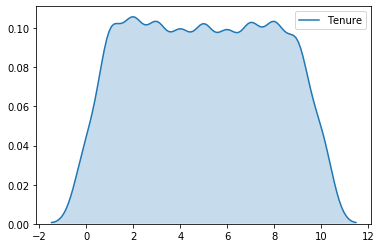

In [8]:
sns.kdeplot(df['Tenure'], shade=True)

#### Заменим пропущенные значения столбца `Tenure` случайным числом (от 0 до 10).

In [9]:
fill_list = [ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.]

In [10]:
np.random.choice(fill_list, len(df))

array([8., 5., 4., ..., 9., 4., 0.])

In [11]:
df['Tenure'] = df['Tenure'].fillna(pd.Series(np.random.choice(fill_list, size=len(df.index))))

#### Посмотрим график распределения после заполнения пропусков.

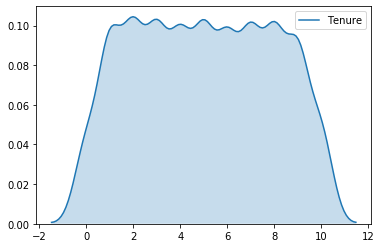

In [12]:
sns.kdeplot(df['Tenure'], shade=True)

*Мы видим, что после заполнения проусков наши данные не сильно изменились*

<a id='section4'></a>

### 2.2. Изменим тип данных.

Изменим тип даных столбца `Tenure` с float на integer.

In [13]:
df['Tenure'] = df['Tenure'].astype(int)

<a id='section5'></a>

### 2.3. Обработаем дубликаты.

Необходимо установить наличие дубликатов. Если найдутся, удаляем, и проверяем, все ли удалились.

In [14]:
df.duplicated().sum()

0

Дубликатов в таблице не обнаружено.

<a id='section6'></a>

# 3. Исследование задачи.

### 3.1. Определим подзадачу обучения с учителем.

Целевым признаком является столбец `Exited` — факт ухода клиента. Это категориальный признак, у которого только две категории, значит, задача относится к бинарной классификации.

<a id='section7'></a>

### 3.2. Подготовим признаки.

#### Требуется изменить следующие признаки:

*Признак `RowNumber`— является индексами строк в данных и не представляет ценности для обучения модели. Поэтому столбец можем удалить.*

*Признак `CustomerId` — является уникальным идентификатором клиента и не представляет ценности для качества будущей модели. Стоблец также можно удалить.*

*Признак `Surname` — является фамилией пользователя и не несет ценности для обучения будущей модели — столбец можно удалить.*

*Признакам `Geography` и `Gender`  требуется преобразование One-hot-encoding.*

#### Удалим признаки не представляющие ценности для качества будущей модели.

In [15]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Данные преобразуем методом One-hot-encoding.

In [16]:
#drop_first=True - удаление первого столбца (избегая дамми-ловушки)
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<a id='section8'></a>

### 3.3. Разбиение данных на выборки.

#### Извлекаем в отдельные переменные признаки и целевой признак.

In [17]:
features = df.drop(['Exited'], axis=1)
target = df['Exited'] 

#### Разделим наш набор данных на следующие выборки:
* 60% - обучающий набор,
* 20% - валидационный набор,
* 20% - тестовый набор.

In [18]:
#Выделим обучающую выборку 60%
#Сделаем доли 0 и 1 в разных выборках одинаковыми параметром stratify 
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

In [19]:
#Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)

#### Выведем размеры выборок после их разбиения.

In [20]:
print('features_train:', features_train.shape)
print('target_train:', target_train.shape)
print('features_valid:', features_valid.shape)
print('target_valid:', target_valid.shape)
print('features_test:', features_test.shape)
print('target_test:', target_test.shape)

features_train: (6000, 11)
target_train: (6000,)
features_valid: (2000, 11)
target_valid: (2000,)
features_test: (2000, 11)
target_test: (2000,)


<a id='section9'></a>

### 3.4. Масштабирование признаков.

#### Для масштабирования зафиксируем численные признаки.

In [21]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

#### Создадим объект структуры StandardScaler() и настроим его на обучающих данных.

In [22]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Сохраним преобразованные выборки.

In [23]:
pd.options.mode.chained_assignment = None #отключение предупреждения

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<a id='section10'></a>

# 4. Исследование моделей.

### 4.1. Проверим баланс классов выборки.

In [24]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [25]:
target_valid.value_counts(normalize = 1)

0    0.7965
1    0.2035
Name: Exited, dtype: float64

*У обучающией и валидационной выборок наблюдается дисбаланс классов.*

<a id='section11'></a>

### 4.2. Исследуем модели на несбалансированных данных.

#### Оценим качество трех моделей несбалансированной выборки.

In [26]:
models = []
# для постоянства результата зададим random_state, равный 12345
models.append(('DTR', DecisionTreeClassifier(random_state=12345)))
models.append(('RFC', RandomForestClassifier(random_state=12345)))
models.append(('LR', LogisticRegression(random_state=12345)))

data = []
results = []
names = []
for name, model in models:
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    result = accuracy_score(target_valid, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    accuracy = "%f" % (result)
    data.append([name, accuracy])
    
#сохраним результаты в отдельную таблицу imbalance_1
imbalance_1 = pd.DataFrame(data, columns=['model', 'accuracy_default'])
imbalance_1

,model,accuracy_default
0,DTR,0.809000
1,RFC,0.846500
2,LR,0.812000


*В оценке качества моделей по умолчанию, лучшей стал алгоритм случайный лес (RandomForestClassifier). Оценим качество моделей и на тренировочной выборке, чтобы понять, насколько переобучается модель.*

#### Оценим качество моделей на тренировочной выборке.

In [27]:
data = []
results = []
names = []
for name, model in models:
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_train) # получаем предсказания модели на тренировочной выборке
    result = accuracy_score(target_train, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    accuracy = "%f" % (result)
    data.append([name, accuracy])
    
imbalance_2 = pd.DataFrame(data, columns=['model', 'accuracy_train']) 
imbalance_2

,model,accuracy_train
0,DTR,1.000000
1,RFC,0.984667
2,LR,0.812833


*Мы видим, что модель Дерево решений переобучилась. Модель Случайного леса близка к переобучению, а вот модель Логистическая регрессия почти не изменилась.*

#### Рассмотрим матрицу ошибок, полноту, точность, f1-меру и AUC-ROC для каждой модели.

In [28]:
data = []
recalls = []
precisions = []
roc_aucs = []
confusions = []
f1_ = []
names = []
for name, model in models:
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    confusion = confusion_matrix(target_valid, predictions) # посчитаем матрицу ошибок
    recall = recall_score(target_valid, predictions) # посчитаем полноту
    precision = precision_score(target_valid, predictions) # посчитаем точность
    roc_auc = roc_auc_score(target_valid, predictions)# посчитаем roc_auc
    f1 = f1_score(target_valid, predictions) # посчитаем f1 метрику
    confusions.append(confusion)
    recalls.append(recall)
    precisions.append(precision)
    roc_aucs.append(roc_auc)
    f1_.append(f1)
    names.append(name)
    data.append([name, confusion, recall, precision, roc_auc, f1])
    
imbalance_3 = pd.DataFrame(data, columns=['model', '[TN, FP], [FN, TP]', 'recall', 'precision', 'roc_auc', 'f1']) 
imbalance_3

,model,"[TN, FP], [FN, TP]",recall,precision,roc_auc,f1
0,DTR,"[[1394, 199], [183, 224]]",0.550369,0.529551,0.712724,0.539759
1,RFC,"[[1520, 73], [234, 173]]",0.425061,0.703252,0.689618,0.529862
2,LR,"[[1546, 47], [329, 78]]",0.191646,0.624000,0.581071,0.293233


*Дерево решений выдаёт позитивные предсказания. Случайный лес склоняется к ложно позитивным предсказаниям (FP). Логистическая регрессия выдает высокую долю негативных ответов в валидационной выборке. Низкое значние F1- меры у всех моделей свидетельствует о низком качестве модели.*

#### Обединим получившие метрики в таблицу imbalance.

In [29]:
imbalance = imbalance_1.merge(imbalance_2, on='model') 
imbalance = imbalance.merge(imbalance_3, on='model') 

<a id='section12'></a>

### 4.3. Борьба с дисбалансом.

#### Придадим объектам редкого класса больший вес.

In [30]:
#создадим функцию для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#### Увеличим количество положительных ответов в 4 раза на тренировачной выборке.

In [31]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [32]:
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: Exited, dtype: float64
(9666,)


*Мы получили сбалансированное количество классов, перейдем к обучению моеделей на новых данных.*

<a id='section13'></a>

### 4.4. Исследуем модели на сбалансированных данных.

#### Оценим качество трех моделей сбалансированной выборки.

In [33]:
models = []
# Придадим объектам редкого класса больший вес, зададим class_weight='balanced'
models.append(('DTR', DecisionTreeClassifier(random_state=12345, class_weight='balanced')))
models.append(('RFC', RandomForestClassifier(random_state=12345, class_weight='balanced')))
models.append(('LR', LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')))

data = []
results = []
names = []
for name, model in models:
    model.fit(features_train_upsampled, target_train_upsampled) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    result = accuracy_score(target_valid, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    accuracy = "%f" % (result)
    data.append([name, accuracy])
    
#сохраним результаты в отдельную таблицу balance_1
balance_1 = pd.DataFrame(data, columns=['model', 'accuracy_default'])
balance_1

,model,accuracy_default
0,DTR,0.799000
1,RFC,0.837000
2,LR,0.700000


*В оценке качества моделей по умолчанию на сбалансированной выборке, лучшей стал опять алгоритм случайный лес (RandomForestClassifier). Оценим качество моделей и на тренировочной выборке, чтобы понять, насколько переобучается модель.*

#### Оценим качество моделей на тренировочной выборке.

In [34]:
data = []
results = []
names = []
for name, model in models:
    model.fit(features_train_upsampled, target_train_upsampled) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_train_upsampled) # получаем предсказания модели на тренировочной выборке
    result = accuracy_score(target_train_upsampled, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    accuracy = "%f" % (result)
    data.append([name, accuracy])
    
balance_2 = pd.DataFrame(data, columns=['model', 'accuracy_train']) 
balance_2

,model,accuracy_train
0,DTR,1.000000
1,RFC,0.999172
2,LR,0.698221


*И снова мы видим, что модель Дерево решений полностью переобучилась. Модель Случайного леса близка к переобучению, и модель Логистическая регрессия почти не изменилась.*

#### Рассмотрим матрицу ошибок, полноту, точность, f1-меру и AUC-ROC для каждой модели.

In [35]:
data = []
recalls = []
precisions = []
roc_aucs = []
confusions = []
f1_ = []
names = []
for name, model in models:
    model.fit(features_train_upsampled, target_train_upsampled) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    confusion = confusion_matrix(target_valid, predictions) # посчитаем матрицу ошибок
    recall = recall_score(target_valid, predictions) # посчитаем полноту
    precision = precision_score(target_valid, predictions) # посчитаем точность
    roc_auc = roc_auc_score(target_valid, predictions)# посчитаем roc_auc
    f1 = f1_score(target_valid, predictions) # посчитаем f1 метрику
    confusions.append(confusion)
    recalls.append(recall)
    precisions.append(precision)
    roc_aucs.append(roc_auc)
    f1_.append(f1)
    names.append(name)
    data.append([name, confusion, recall, precision, roc_auc, f1])
    
balance_3 = pd.DataFrame(data, columns=['model', 'confusion_matrix', 'recall', 'precision', 'roc_auc', 'f1']) 
balance_3

,model,confusion_matrix,recall,precision,roc_auc,f1
0,DTR,"[[1407, 186], [216, 191]]",0.469287,0.506631,0.676263,0.487245
1,RFC,"[[1473, 120], [206, 201]]",0.493857,0.626168,0.709264,0.552198
2,LR,"[[1125, 468], [132, 275]]",0.675676,0.370121,0.690945,0.478261


#### Обединим получившие метрики в таблицу balance.

In [36]:
balance = balance_1.merge(balance_2, on='model') 
balance = balance.merge(balance_3, on='model')

<a id='section14'></a>

### 4.5. Сравним показатели на сбалансированных и несбалансированных данных.

In [37]:
balance

,model,accuracy_default,accuracy_train,confusion_matrix,recall,precision,roc_auc,f1
0,DTR,0.799000,1.000000,"[[1407, 186], [216, 191]]",0.469287,0.506631,0.676263,0.487245
1,RFC,0.837000,0.999172,"[[1473, 120], [206, 201]]",0.493857,0.626168,0.709264,0.552198
2,LR,0.700000,0.698221,"[[1125, 468], [132, 275]]",0.675676,0.370121,0.690945,0.478261


In [38]:
imbalance

,model,accuracy_default,accuracy_train,"[TN, FP], [FN, TP]",recall,precision,roc_auc,f1
0,DTR,0.809000,1.000000,"[[1394, 199], [183, 224]]",0.550369,0.529551,0.712724,0.539759
1,RFC,0.846500,0.984667,"[[1520, 73], [234, 173]]",0.425061,0.703252,0.689618,0.529862
2,LR,0.812000,0.812833,"[[1546, 47], [329, 78]]",0.191646,0.624000,0.581071,0.293233


*Мы наблюдаем, что качество моделей после балансировки выборок не сильно изменилось. Так же как и  показатели полноты, точности, f1-меры и AUC-ROC всех моделей. Лучшие результаты показывает Случайный лес. На валидационной выборке RandomForestClassifier показывает результаты F1 меры = 0.54, что ниже целевого значения.
Попробуем улучшить модель путем изменения гиперпараметров.*

<a id='section15'></a>

### 4.6. Улучшим модель.

Настроим гиперпараметры модели Случайный лес (RandomForestClassifier). Для этого нам необходимо перебрать разные значения по методу RandomizedSearchCV.

In [39]:
model_RFC = RandomForestClassifier(random_state=12345, class_weight='balanced')

In [40]:
#Создаем сетку гиперпараметров
parametrs = {'n_estimators': range (10, 100, 10),
             'criterion': ['entropy', 'gini'],
             'max_features': ['auto', 'sqrt','log2', None],
             'max_depth': range (1,15,),
             'min_samples_leaf': range (1,15)}
clf = RandomizedSearchCV(model_RFC, parametrs, random_state=12345)

#Запускаем обучение
clf.fit(features_train_upsampled, target_train_upsampled)

#Выводим результат
clf.best_params_

{'n_estimators': 50,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini'}

In [41]:
#Обучаем модель RFC с лучшим гиперпараметрами
model_RFC = RandomForestClassifier(
    random_state=12345, n_estimators=30, max_depth=10, min_samples_leaf=4, criterion='gini', class_weight='balanced', max_features='auto')
model_RFC.fit(features_train, target_train)
predictions_valid = model_RFC.predict(features_valid) 
f1 = f1_score(target_valid, predictions_valid)
print('Метрика f1 RFC модели:', f1)

Метрика f1 RFC модели: 0.6068476977567886


*Мы достигли результат F1 меры > 0.59.*

Для понимания, какие факторы важны при моделировании, выведим их важность и построим график.

              feature  importance
0                 Age    0.323381
1       NumOfProducts    0.190978
2             Balance    0.117885
3     EstimatedSalary    0.087090
4         CreditScore    0.084134
5      IsActiveMember    0.065110
6              Tenure    0.043492
7   Geography_Germany    0.042819
8         Gender_Male    0.020876
9     Geography_Spain    0.012145
10          HasCrCard    0.012091


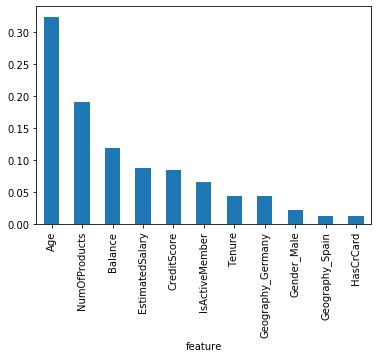

In [42]:
importances = model_RFC.feature_importances_


feature_list = list(features_train_upsampled.columns)

# Извлекаем важность функции в фрейм данных.
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})


feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

print(feature_results)
feature_results.set_index('feature')['importance'].plot(kind='bar')

*Самыми значимыми признаками являются: возраст, количество продуктов банка, используемых клиентом, баланс на счёте. А вот такие признаки как, страна проживания, наличие кредитной карты и пол, не имеют большого значения для нашей модели.*

### ВЫВОД 

На этапе исследования моделей, мы определили, что качество моделей после балансировки выборок не сильно меняется, так же как и показаели полноты, точности, f1-меры и AUC-ROC. Лучшие результаты показала модель Случайный лес. Для улучшения этой модели мы настроили гиперпараметры. И на валидационной выборке RandomForestClassifier показала результат f1-меры равной 0,61.

<a id='section16'></a>

# 5. Тестирование модели.

### 5.1. Объединим тренировачную и валидационную выборки.

In [43]:
features_train_valid = pd.concat([features_train_upsampled, features_valid])
target_train_valid = pd.concat([target_train_upsampled, target_valid])

<a id='section17'></a>

### 5.2. Обучим модель, получим предсказания и посчитаем качество модели на тестовой выборке.

In [44]:
model_RFC.fit(features_train_valid, target_train_valid)
predictions_test = model_RFC.predict(features_test)
accuracy_score_test = accuracy_score(target_test, predictions_test)
print('Метрика accuracy RFC модели:', accuracy_score_test)

Метрика accuracy RFC модели: 0.84


<a id='section18'></a>

### 5.3. Посчитаем полноту, точность, AUC-ROC и  f1-меру финальной модели на тестовой выборке.

In [45]:
f1_test = f1_score(target_test, predictions_test) # посчитаем f1-меру модели
recall = recall_score(target_test, predictions_test) # посчитаем полноту
precision = precision_score(target_test, predictions_test) # посчитаем точность
roc_auc = roc_auc_score(target_test, predictions_test)# посчитаем roc_auc
print('Полнота RFC модели:', recall)
print('Точность RFC модели:', precision)
print('AUC-ROC RFC модели:', roc_auc)
print('Метрика f1 RFC модели:', f1_test)

Полнота RFC модели: 0.7401960784313726
Точность RFC модели: 0.5852713178294574
AUC-ROC RFC модели: 0.8028869839393044
Метрика f1 RFC модели: 0.6536796536796536


<a id='section19'></a>

### 5.5. Построим ROC-кривую.

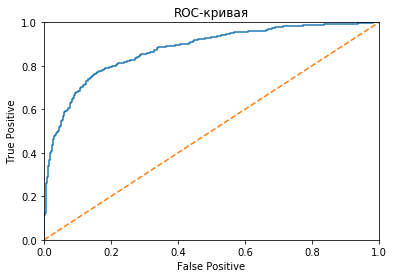

In [46]:
final_model_proba = model_RFC.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_proba) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC-кривая')
plt.show()

*Финальная модель достигла заданной метрики (F1 > 0.59) и показывает адекватные результаты.
Модель характеризуется высоким показателем полноты и точности, поэтому она с высокой вероятностью предскажет уход клиента из банка.*

<a id='section20'></a>

# 6. Проверка модели на адекватность.

### 6.1. Создадим константную модель.

In [47]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train_valid, target_train_valid)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(features_train_valid)
dummy_clf.score(features_train_valid, target_train_valid)

0.5461169209669124

<a id='section21'></a>

### 6.2. Сравним показатель точности константной модели и финальной.

In [48]:
print('accuracy_score константой модели:', dummy_clf.score(features_train_valid, target_train_valid))
print('accuracy_score финальной модели:', accuracy_score(target_test, predictions_test))

accuracy_score константой модели: 0.5461169209669124
accuracy_score финальной модели: 0.84


*Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.*

<a id='section22'></a>

# 7. Общий вывод

На основе предоставленных нам данных, мы получили общее представление о поведении клиентов и расторжении договоров с банком. Нам необходимо было  построить модель для задачи классификации, которая спрогнозирует, уйдёт клиент из банка в ближайшее время или нет.
    
Для постройки модели мы использовали готовые библиотеки `Scikit-Learn`.
    
На этапе предобработки в данных обнаружилось небольшое количество пропусков. Пропущенные значения составляли около 9% данных, и мы не смогли их просто удалить. Мы старались сохранить данные максимально точно, поэтому мы заполнили пропущенные значения случайным числом методом `fillna()`. Изменили тип данных в некоторых столбцах с float на integer методом `astype()` для удобства расчётов. 
    
Далее мы исследовали задачу и определили что, задача относится к бинарной классификации т.к. целевой признак (столбец Exited)  является категориальным признаком, у которого только две категории.
    
После этого, нам необходимо было подготовить признаки.  Мы проанализировали каждый признак и удалили те столбцы,  которые  не представляли ценности для качества будущей модели. А так же преобразовали некоторые признаки методом `One-hot-encoding`.
    
Затем мы извлекли в отдельные переменные признаки и целевой признак. А после этого,  воспользовались одним из методов масштабирования — стандартизации данных ` StandardScaler ` и привели численные признаки к одному масштабу.
    
Для построения предсказательной модели мы разбили исходные данные на обучающую, валидационную и тестовую выборки, в соотношении 60% – 20% – 20% объема исходных данных. Осуществили разделение данных методом `train_test_split()`.
    
Следующим этапом нашей работы стал - исследование моделей.  Для начала, мы проверили баланс классов выборки, и обнаружили дисбаланс классов.
    
Затем, мы приступили к исследованию моделей на несбалансированных данных. Мы оценили качество трех моделей, таких как, дерево решений, случайный лес и логистическая регрессия. Также, мы оценили модели на обучающей выборке, чтобы посмотреть, как сильно переобучаются модели. Посчитали матрицу ошибок, полноту, точность, f1-меру и AUC-ROC для каждой модели. Дерево решений выдаёт позитивные предсказания. Случайный лес склоняется к ложно позитивным предсказаниям. Логистическая регрессия выдает высокую долю негативных ответов в валидационной выборке. Так же мы получили низкое значение F1- меры у всех моделей, это говорит о том, что качество моделей низкое.
    
Далее мы придали объектам редкого класса больший вес. Для этого создали функцию для увеличения выборки и увеличили количество положительных ответов в 4 раза.
    
Затем, мы приступили к исследованию моделей уже на сбалансированных данных. И определили, что качество моделей после балансировки выборок не сильно меняется, так же как и показаели полноты, точности, f1-меры и AUC-ROC. Лучшие результаты показал Случайный лес. После этого, мы попробовали улучшить модель путем изменения гиперпараметров. Для этого мы перебрали разные значения по методу `RandomizedSearchCV`. И на валидационной выборке RandomForestClassifier показала результат f1-меры равной 0,61.
    
Далее, мы объединили тренировочную и валидационную выборку и обучили модель на полных данных.
    
После, проверили модель на тестовой выборке. Качество финальной модели на тестовой выборке показало 83%.  После, посчитали полноту, точность, AUC-ROC и f1-меру финальной модели на тестовой выборке.
    
Финальная модель достигла метрики F1 = 0,65 и показывает адекватные результаты. Модель характеризуется высоким показателем полноты и точности, поэтому она с высокой вероятностью предскажет уход клиента из банка.
    
И последним шагом, нам оставалось проверить модель на адекватность. Для этого необходимо было сравнить качество финальной модели с качеством наилучшей константной модели, в этом нам помог метод `DummyClassifier`. Финальная модель показала результаты лучше, чем константная модель, значит, финальную модель можно считать адекватной.
    
Таким образом, полученная модель поможет маркетологам лучше определять поведение клиентов,  которые могут уйти в ближайшее время.